This script simulates multiple state trajectories according to the paper "Particle Mobility Analysis Using Deep Learning and the Moment Scaling Spectrum". 

<a id='Code_overview'></a>
**Code overview:** 

* **Section 1**: [Initialization cells (importing and functions)](#Initialization_cells) 
  <br>Run initialization cells by clicking the *'Run all initialization cells'* button (or by running all cells in **Section 6** ([Initialization code cells](#Initialization_code_cells)) manually). Progress is shown in the progress bar.


* **Section 2**: [Parameters](#Parameters)
  <br>Specify parameters for simulated trajectories.
 
 
* **Section 3**: [Get tracks](#Get_tracks)
  <br>Simulate trajectories.
  
  
* **Section 4**: [Save tracks](#Save_tracks)
  <br>Save trajectories in specified directory.
  
  
* **Section 5**: [Get tracks](#Plot_tracks)
  <br>Plot trajectories in xy-space.
  

<a id='Initialization_cells'></a>
### Initialization cells (importing and functions)
[Back to code overview](#Code_overview)

In [10]:
# draw a bar that shows that the initialization is finished
from ipywidgets import FloatProgress
from IPython.display import display
initialization_bar = FloatProgress(min = 0, max = 1,description='Initializing:', bar_style='success')
initialization_bar.value = 0
display(initialization_bar)

FloatProgress(value=0.0, bar_style='success', description='Initializing:', max=1.0)

<a id='Parameters'></a>
### Parameters
[Back to code overview](#Code_overview)

In [123]:
# Parameters
tmin = 4 # Minimal amount of frames [frames]
beta = 100 # Mean of exponential distribution to get track lengths [frames]
N = 100 # Number of particles
t = 0.03 # Time step [sec]
pixsize = 0.100 # Pixel size [\mu m]
imsize = [100, 100] # Image size [pixels]

diffs = [1, 2] # Diffusion constants for diffusive states [um^2/sec]
nondiffs = [[0.1, 0.2], [0.7, 0.8]] # Hurst component and scaling factor for non-diffusive states

# Use automatic generation of probability transition matrix, the probability to switch to any other state is 0.1:
P = 'auto' 
# Or specify a custom probability transition matrix with shape [#states x #states]:
# P = [[...]]

n_interval = 10 # Parameter for restricted motion
M = 20 # Parameter for restricted motion
min1state = 4 # Minimum amount of frames that the molecule remains in the same state

<a id='Get_tracks'></a>
### Get tracks
[Back to code overview](#Code_overview)

In [124]:
stateVector = diffs + nondiffs # All states together
numStates = len(stateVector) # Number of states

# Probability transition matrix
if P == 'auto':
    ptm = np.zeros(numStates) + 0.1 + (1 - numStates / 10) * np.identity(numStates)
else:
    ptm = P

# Call function CumCoord to get the tracks
Xcum, Ycum, StateList = CumCoord(beta, N, tmin, stateVector, ptm, t, imsize, pixsize, min1state)

# print(StateList) # Print list of states per simulated trajectory if wanted

A Jupyter Widget

<a id='Save_tracks'></a>
### Save tracks
[Back to code overview](#Code_overview)

In [11]:
# Save X-coordinates, Y-coordinates and states
picklename = 'FilenameWithDirectory.p' # File to save in, should always end with .p

print(picklename)

pickle.dump({'Xcum':Xcum, 'Ycum':Ycum, 'StateList':StateList}, open( picklename, "wb" )) # Save file

Tracks10000_3state_minFrames1state4_P[[0.8,0.1,0.1],[0.1,0.8,0.1],[0.1,0.1,0.8]]_D[1.0,0.1]_H0.1_scaling0.3_t0.03_pixsize0.1.p


<a id='Plot_tracks'></a>
### Plot tracks
[Back to code overview](#Code_overview)

A Jupyter Widget

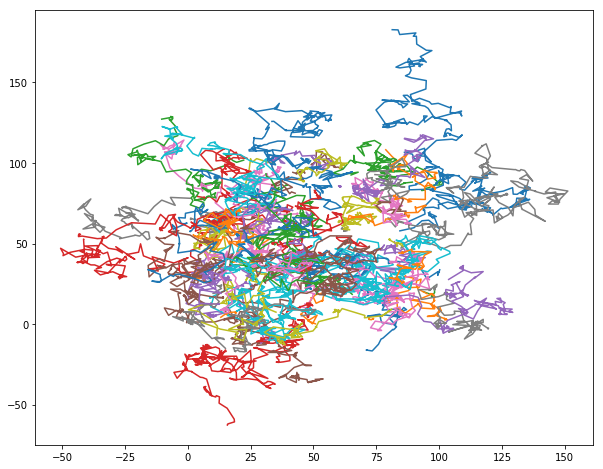

In [131]:
# Plot the tracks
g = FloatProgress(min = 0, max = 100, description = 'Plotting:', bar_style = 'success')
display(g)
for i in range(N):
    plt.plot(Xcum[i], Ycum[i])
    if (100 / N) * (i + 1) % 10 == 0:
        g.value = (100 / N) * (i + 1)
# plt.savefig('tracks.pdf') # Save figure if wanted

<a id='Initialization_code_cells'></a>
### Initialization code cells
[Back to code overview](#Code_overview)

#### Importing

In [11]:
# Import and set
import numpy as np # For calculations
from ipywidgets import FloatProgress # For progressionbar
from IPython.display import display # For progressionbar
from matplotlib import pyplot as plt # For plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # To make figures bigger
import pickle # For saving tracks
from scipy.special import gamma # Gamma distribution

#### Functions

In [12]:
# Function that generates the amount of steps in current state and the new state to switch to
def NumSteps(s, P, min1state):
    steps = min1state + int(np.random.geometric(1 - P[s][s]))
    newstate = np.delete(np.arange(numStates), s)[np.random.randint(numStates - 1)]
    
    return steps, newstate

In [13]:
# Simulation according to the book "Fractals" (Feder J, Springer, 1988) page 174, eq. 9.25
def fBm(t, ksi, H):
    sum1 = np.array([i ** (H - 0.5) * ksi[1 + n_interval * (M + t) - i] \
                     for i in np.arange(1, n_interval)]).sum()
    sum2 = np.array([((n_interval + i) ** (H - 0.5) - i ** (H - 0.5)) * ksi[1 + n_interval * (M - 1 + t) - i] \
                     for i in np.arange(1, n_interval * (M - 1))]).sum()
    return n_interval ** (-H) / gamma(H + 0.5) * (sum1 + sum2) 

In [14]:
# Function to get the cumulative sum of the coordinates for the tracks. Also returns a list of states. 
# Uses function NumSteps and fBm
def CumCoord(beta, N, tmin, stateVector, P, t, imsize, pixsize, min1state):
    
    # Progress bar
    f = FloatProgress(min = 0, max = 100, description = 'Computing:', bar_style = 'info')
    display(f)
    
    # Random track lengths from exponential distribution
    TrackLength = np.around(np.random.exponential(beta, N) + tmin) 
    
    # Get random initial states (0 or 1)
    states_init = np.random.randint(numStates, size = N)
    print(states_init)
    
    # Empty lists for cumulative sum of X and Y
    Xcum = []
    Ycum = []
    
    StateList = []
    
    for j in range(N):
        s = int(states_init[j]) # Start with initial state
        Tr = TrackLength[j]
        stepstaken = 0
        
        # Initialize coordinate arrays (extra place to put initial coordinate)
        X = np.zeros(int(Tr) + 1)
        Y = np.zeros(int(Tr) + 1)
        
        # Get random initial coordinates
        startX = np.random.random() * imsize[0]
        startY = np.random.random() * imsize[1]
        X[0] = startX
        Y[0] = startY
        
        # Initialize states array
        states = np.zeros(int(Tr) + 1)
        states[0] = s
        
        
        while stepstaken < int(Tr): # While inside the track length
            steps, newstate = NumSteps(s, P, min1state) # Get amount of steps taken and return new state
            
            # Condition to make sure the amount of steps does not exceed the track length
            if stepstaken + steps > int(Tr):
                steps = int(Tr) - stepstaken
            
            # Save states per step
            states[stepstaken + 1:stepstaken + 1 + steps] = s
            
            # Get coordinates 
            if s < len(diffs): # Diffusion
                for k in range(stepstaken, stepstaken + steps):
                    X[(k + 1)] = np.random.normal(0, np.sqrt(2 * stateVector[s] * t)) / pixsize
                    Y[(k + 1)] = np.random.normal(0, np.sqrt(2 * stateVector[s] * t)) / pixsize         
            else: # Non-diffusive processes
                ksix = np.random.normal(0, 1, (M + steps + 1) * n_interval)
                X[(stepstaken + 1):(stepstaken + steps + 1)] = \
                [fBm(j, ksix, stateVector[s][0]) * stateVector[s][1] for j in np.arange(1, steps + 1)]
                ksiy = np.random.normal(0, 1, (M + steps + 1) * n_interval)
                Y[(stepstaken + 1):(stepstaken + steps + 1)] = \
                [fBm(j, ksiy, stateVector[s][0]) * stateVector[s][1] for j in np.arange(1, steps + 1)]
                
                
            # Update the state and the amount of steps taken
            s = newstate
            stepstaken += steps
        
        else: # When the array with coordinates is finished, add to cumsum list
            Xcum.append(np.cumsum(X))
            Ycum.append(np.cumsum(Y))
            StateList.append(states)
        
        # Update progressbar
        if (100 / N) * (j + 1) % 10 == 0:
            f.value = (100 / N) * (j + 1)
    
    return Xcum, Ycum, StateList

In [15]:
# execution of initialization cells is done
initialization_bar.value += 1